# New evaluation test set playground

this file will be used to test different finetuned models. everytime it is used, please save the results in a different copy and leave this file as clean as possible 

Changes:


In [2]:
import os
import numpy as np
import json
import pandas as pd
from birdnetlib.analyzer import Analyzer
from birdnetlib.batch import DirectoryAnalyzer
import matplotlib.pyplot as plt 

## test the model and extract predictions

In [53]:
# open best_threshold_by_species
with open("utils/best_threshold_by_species.json") as f:
    best_threshold_by_species = json.load(f)

In [55]:
# apply threshold in pred_segments
best_threshold_by_species

{'Certhia familiaris_Eurasian Treecreeper': 0.3260695452641959,
 'Dendrocopos major_Great Spotted Woodpecker': 0.2595857083797455,
 'Dryocopus martius_Black Woodpecker': 0.4141795039176941,
 'Erithacus rubecula_European Robin': 0.28878992795944214,
 'Fringilla coelebs_Common Chaffinch': 0.250076025724411,
 'Lophophanes cristatus_Crested Tit': 0.8359681638804349,
 'Loxia curvirostra_Common Crossbill': 0.5784583434914098,
 'Muscicapa striata_Spotted Flycatcher': 0.26079103350639343,
 'Pecking_': 0.8979470868303319,
 'Periparus ater_Coal Tit': 0.31581333490333174,
 'Phylloscopus collybita_Common Chiffchaff': 0.25949913263320923,
 'Rain_': 0.2611730992794037,
 'Regulus ignicapilla_Common Firecrest': 0.3331939180692037,
 'Regulus regulus_Goldcrest': 0.2554644460629935,
 'Sylvia atricapilla_Eurasian Blackcap': 0.42233136868236043,
 'Troglodytes troglodytes_Eurasian Wren': 0.25160735845565796,
 'Turdus merula_Eurasian Blackbird': 0.5913880955089222,
 'Turdus philomelos_Song Thrush': 0.2650089

In [57]:
# E:\Giacomo\Tovanella-20241110T120546Z-001\training_sessions\session_0\test\Certhia familiaris_Eurasian Treecreeper\20200217_160000_591.wav
# salva tutti i risultati su questo array
complete_pred_segments = {}
def on_analyze_complete(recording):
    # E:\Giacomo\Tovanella-20241110T120546Z-001\test_set_augm\test\Periparus ater_Coal Tit\20200215_090000_88.wav
    audio_name = recording.path.split('\\')[-1]
    date, number, segm_id = audio_name.split('_')    # <20200215>_<090000>_<88.wav>
    segm_id = segm_id.split('.')[0]               # <88>.<wav>
    audio_name = "_".join([date, number]) + ".WAV"      # 20200215_090000.WAV
    if audio_name not in complete_pred_segments:
        complete_pred_segments[audio_name] = {}
    if segm_id not in complete_pred_segments[audio_name]:
        complete_pred_segments[audio_name][segm_id] = {}
    complete_pred_segments[audio_name][segm_id] = { 
        detection["label"]: detection["confidence"] for detection in recording.detections 
        if detection["confidence"] > best_threshold_by_species[detection["label"]] 
    }
    print("Analyzing ", recording.path)

def on_error(recording, error):
    print("An exception occurred: {}".format(error))
    print(recording.path)

In [58]:
complete_pred_segments = {}
model_name = "wabad_augm_2"
model_path = f"classifiers/{model_name}/CustomClassifier.tflite"
labels_path = f"classifiers/{model_name}/CustomClassifier_Labels.txt"
audio_path = "E:/Giacomo/Tovanella-20241110T120546Z-001/test_set_augm/test"
min_conf = 0.1

analyzer = Analyzer(
    classifier_labels_path=labels_path, 
    classifier_model_path=model_path,
)      

load_custom_models
Custom model loaded.
loading custom classifier labels
Labels loaded.
load model False
Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.


In [59]:
for folder in os.listdir(audio_path):
    directory = os.path.join(audio_path, folder)

    print("Starting Watcher: ", folder)
    batch = DirectoryAnalyzer(
        directory,
        analyzers=[analyzer],
        min_conf=min_conf,
    )

    batch.on_analyze_complete = on_analyze_complete
    batch.on_error = on_error
    batch.process()

Starting Watcher:  Certhia familiaris_Eurasian Treecreeper
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording 20190621_170000_10.wav
Analyzing  E:\Giacomo\Tovanella-20241110T120546Z-001\test_set_augm\test\Certhia familiaris_Eurasian Treecreeper\20190621_170000_10.wav
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording 20190621_170000_15.wav
Analyzing  E:\Giacomo\Tovanella-20241110T120546Z-001\test_set_augm\test\Certhia familiaris_Eurasian Treecreeper\20190621_170000_15.wav
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording 20190621_170000_17.wav
Analyzing  E:\Giacomo\Tovanella-20241110T120546Z-001\test_set_augm\test\Certhia familiaris_Eurasian Treecreeper\20190621_170000_17.wav
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording 20190621_170000_18.wav
Analyzing  E:\Giacomo\Tovanella-20241110T120546Z-001\test_set_augm\test\Certhia familiaris_Eurasian Treecreeper\20190621_170000_18.wav
r

In [60]:
# SAVE
# with open(f"classifiers/{model_name}/complete_pred_segments_{str(min_conf).replace('.', '_')}.json", "w") as f:
#     json.dump(complete_pred_segments, f)

In [61]:
# LOAD
# with open(f"classifiers\\{model_name}\\complete_pred_segments_{str(min_conf).replace('.', '_')}.json") as f:
#     complete_pred_segments = json.load(f)

## extract predicted and true segments 

In [62]:
pred_segments = {audio: { 
        key: list(value.keys()) for key, value in complete_pred_segments[audio].items()
    } for audio in complete_pred_segments.keys() }
pred_segments["20200215_110000.WAV"]

{'67': [], '68': [], '69': [], '70': []}

In [63]:
with open("utils/true_segments.json") as f:
    all_segments = json.load(f)
# filter segments in true_segments from the ones not present in pred
true_segments = {audio: { 
        key: value for key, value in all_segments[audio].items() if key in pred_segments[audio]
    } for audio in all_segments.keys() if audio in pred_segments}
true_segments["20200215_110000.WAV"]

{'67': ['Wind_'], '68': ['Wind_'], '69': ['Wind_'], '70': ['Wind_']}

## get results

In [64]:
from sklearn.preprocessing import MultiLabelBinarizer

species_list = os.listdir(audio_path)

mlb = MultiLabelBinarizer()
mlb.fit([list(species_list)])

len(mlb.classes_)

25

### side quest: get confidence scores for each label

In [65]:
conf_scores = { specie: [] for specie in species_list }
for audio in pred_segments:
    for segm, species in pred_segments[audio].items():
        for specie in species:
            if specie not in species_list:
                continue
            conf_scores[specie].append([complete_pred_segments[audio][segm][specie], specie in true_segments[audio][segm]])
conf_scores["Dendrocopos major_Great Spotted Woodpecker"]

[[0.37323442101478577, True],
 [0.38606294989585876, True],
 [0.9942935109138489, True],
 [0.9921521544456482, True],
 [0.9856369495391846, True],
 [0.9317321181297302, True],
 [0.6747986674308777, True]]

In [66]:
# with open("utils/conf_scores.json", "w") as f:
#     json.dump(conf_scores, f)

### classification report

In [67]:
y_pred = []
y_true = []
for audio in pred_segments:
    # sort in increasing order
    sortable_true_segments = { int(key): value for key, value in true_segments[audio].items() }
    sortable_pred_segments = { int(key): value for key, value in pred_segments[audio].items() }
    sorted_true_segments = dict(sorted(sortable_true_segments.items()))
    sorted_pred_segments = dict(sorted(sortable_pred_segments.items()))
    y_true.append(mlb.transform(sorted_true_segments.values()))     # apply transform on every label of every segment
    y_pred.append(mlb.transform(sorted_pred_segments.values()))     # apply transform on every label of every segment

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

c:\Users\giaco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Aeroplane_'] will be ignored
  warnings.warn(
c:\Users\giaco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['unknown_'] will be ignored
  warnings.warn(


In [68]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0, output_dict=True)
# apply colors
# add index column name to df
report_df = pd.DataFrame(report).T
# report_df.sort_values(by=["recall"], ascending=False)
report_df

,precision,recall,f1-score,support
Certhia familiaris_Eurasian Treecreeper,1.000000,0.086957,0.160000,23.0
Dendrocopos major_Great Spotted Woodpecker,1.000000,0.466667,0.636364,15.0
Dryocopus martius_Black Woodpecker,1.000000,0.272727,0.428571,11.0
Erithacus rubecula_European Robin,0.687500,0.423077,0.523810,26.0
Fringilla coelebs_Common Chaffinch,0.566210,0.276786,0.371814,448.0
Lophophanes cristatus_Crested Tit,1.000000,0.052632,0.100000,19.0
Loxia curvirostra_Common Crossbill,0.583333,0.518519,0.549020,27.0
Muscicapa striata_Spotted Flycatcher,1.000000,0.729730,0.843750,74.0
Pecking_,0.700000,0.538462,0.608696,13.0
Periparus ater_Coal Tit,0.892857,0.438596,0.588235,57.0


### auc roc

In [69]:
y_pred_conf = []

for audio in pred_segments:
    scores_pred = []
    for segm, predictions in complete_pred_segments[audio].items():
        segm_conf_score = np.zeros(len(mlb.classes_))  # Vettore inizializzato a 0 per tutte le classi

        for pred, conf in predictions.items():
            binary_vector = mlb.transform([[pred]])[0]  # Convertiamo in binario (shape: (n_classes,))
            segm_conf_score += binary_vector * conf  # Moltiplichiamo per il confidence score

        scores_pred.append(segm_conf_score)  # Ogni segmento ora ha un array della stessa lunghezza di n_classes
    
    y_pred_conf.append(np.array(scores_pred))  # Lista di array uniformi

# Convertiamo in un array 2D
y_pred_conf = np.vstack(y_pred_conf)

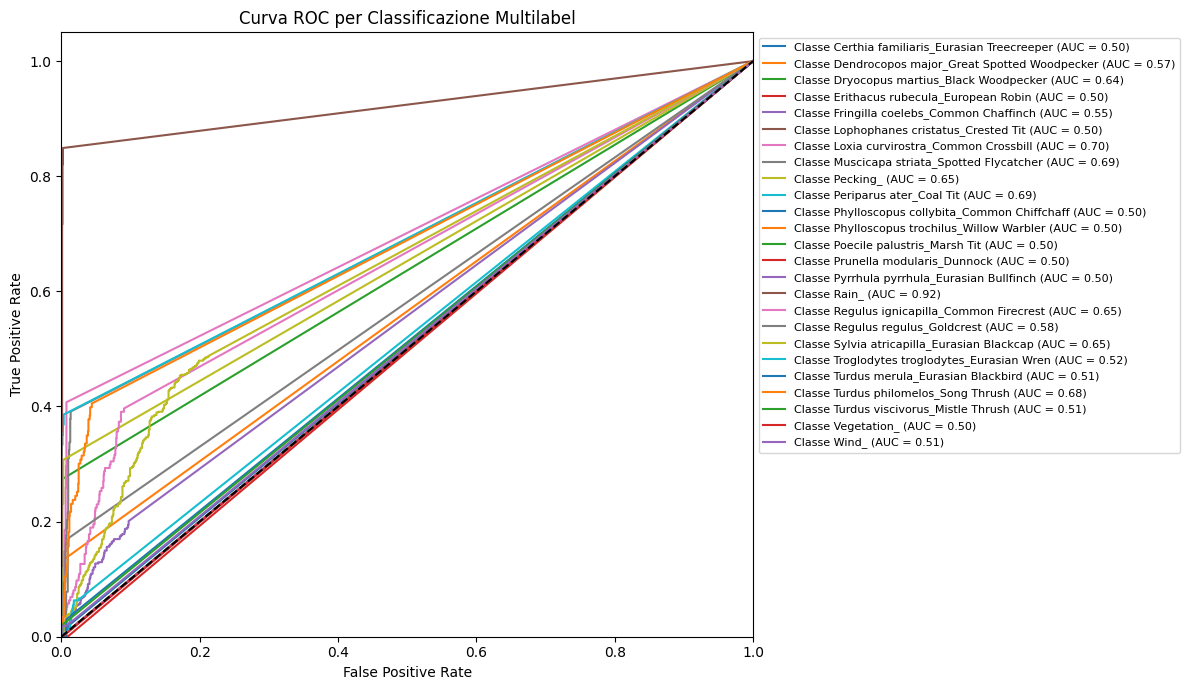

In [70]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(12, 7))  # Aumenta la dimensione
n_classes = len(mlb.classes_)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_conf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Classe {mlb.classes_[i]} (AUC = {roc_auc:.2f})')

# Linea di riferimento
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC per Classificazione Multilabel')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)
plt.tight_layout()
plt.show()